Manual data entry of Copenhagen districts with latitude and longitude.

In [148]:
import pandas as pd
df_copenhagen = pd.DataFrame([["Indre By", "55.68", "12.58"], ["Østerbro", "55.711", "12.578"], ["Nørrebro", "55.688333", "12.559722"], ["Vesterbro/Kongens Enghave", "55.6667", "12.55"], ["Valby", "55.660833", "12.503611"], ["Vanløse", "55.6875", "12.48"], ["Brønshøj-Husum", "55.7075", "12.4914"], ["Bispebjerg", "55.708333", "12.533333"], ["Amager Øst", "55.6625", "12.6253"], ["Amager Vest", "55.641667", "12.578056"], ["Frederiksberg", "55.6775", "12.533889"]], columns=['District', 'Latitude', 'Longitude'])
df_copenhagen

,District,Latitude,Longitude
0,Indre By,55.68,12.58
1,Østerbro,55.711,12.578
2,Nørrebro,55.688333,12.559722
3,Vesterbro/Kongens Enghave,55.6667,12.55
4,Valby,55.660833,12.503611
5,Vanløse,55.6875,12.48
6,Brønshøj-Husum,55.7075,12.4914
7,Bispebjerg,55.708333,12.533333
8,Amager Øst,55.6625,12.6253
9,Amager Vest,55.641667,12.578056


In [149]:
#!conda install -c conda-forge folium --yes
import folium
import requests
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

First we show a map of the districts in Copenhagen, shown as blue dots.

In [150]:
latitude = 55.676111
longitude = 12.568889
map_copenhagen = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, district in zip(df_copenhagen['Latitude'], df_copenhagen['Longitude'], df_copenhagen['District']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_copenhagen)  
    
map_copenhagen

In [151]:
# The code was removed by Watson Studio for sharing.

In [152]:
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [153]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Then we use the Foursquare API to find a list of venues in Copenhagen, and create a dataframe with this data.

In [154]:
copenhagen_venues = getNearbyVenues(names=df_copenhagen['District'],
                                   latitudes=df_copenhagen['Latitude'],
                                   longitudes=df_copenhagen['Longitude']
                                  )

Indre By
Østerbro
Nørrebro
Vesterbro/Kongens Enghave
Valby
Vanløse
Brønshøj-Husum
Bispebjerg
Amager Øst
Amager Vest
Frederiksberg


We find 778 venues in total in the districts.

In [155]:
copenhagen_venues.shape

(778, 7)

We select all the venues that are labelled as restaurants of various kinds.

In [156]:
copenhagen_restaurants = copenhagen_venues[copenhagen_venues['Venue Category'].str.contains("Restaurant")]
copenhagen_restaurants.shape

(169, 7)

We then apply a one-hot encoding to the Venue Category.

In [157]:
# one hot encoding
copenhagen_restaurants_onehot = pd.get_dummies(copenhagen_restaurants[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
copenhagen_restaurants_onehot['District'] = copenhagen_restaurants['District'] 

# move neighborhood column to the first column
fixed_columns = [copenhagen_restaurants_onehot.columns[-1]] + list(copenhagen_restaurants_onehot.columns[:-1])
copenhagen_restaurants_onehot = copenhagen_restaurants_onehot[fixed_columns]

copenhagen_restaurants_onehot.head()

,District,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,Chinese Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Greek Restaurant,...,Scandinavian Restaurant,Seafood Restaurant,South American Restaurant,South Indian Restaurant,Spanish Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
18,Indre By,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
19,Indre By,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
20,Indre By,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22,Indre By,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
27,Indre By,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [158]:
copenhagen_summed = copenhagen_restaurants_onehot.groupby('District').sum().reset_index()
copenhagen_summed

,District,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,Chinese Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Greek Restaurant,...,Scandinavian Restaurant,Seafood Restaurant,South American Restaurant,South Indian Restaurant,Spanish Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Amager Vest,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,Amager Øst,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,3,0,1,0,0
2,Bispebjerg,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,2,0,2,0,0
3,Brønshøj-Husum,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,2,0,0,0,0
4,Frederiksberg,0,0,1,0,1,0,0,5,1,...,6,0,0,1,0,3,0,2,0,0
5,Indre By,0,0,1,1,0,0,0,4,0,...,5,1,1,0,0,0,1,0,1,0
6,Nørrebro,1,0,0,0,0,2,0,1,1,...,2,2,0,0,1,1,1,3,1,1
7,Valby,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,4,0,1,0,1
8,Vanløse,0,0,0,0,0,0,3,0,1,...,2,0,0,0,0,1,0,0,0,0
9,Vesterbro/Kongens Enghave,0,0,0,0,1,1,1,0,2,...,5,2,0,1,0,1,1,1,0,1


In [159]:
copenhagen_grouped = copenhagen_restaurants_onehot.groupby('District').mean().reset_index()
copenhagen_grouped

,District,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,Chinese Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Greek Restaurant,...,Scandinavian Restaurant,Seafood Restaurant,South American Restaurant,South Indian Restaurant,Spanish Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Amager Vest,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Amager Øst,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.166667,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.166667,0.000000,0.000000
2,Bispebjerg,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.125000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.250000,0.000000,0.000000
3,Brønshøj-Husum,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000
4,Frederiksberg,0.000000,0.000000,0.034483,0.000000,0.034483,0.000000,0.000000,0.172414,0.034483,...,0.206897,0.000000,0.000000,0.034483,0.000000,0.103448,0.000000,0.068966,0.000000,0.000000
5,Indre By,0.000000,0.000000,0.043478,0.043478,0.000000,0.000000,0.000000,0.173913,0.000000,...,0.217391,0.043478,0.043478,0.000000,0.000000,0.000000,0.043478,0.000000,0.043478,0.000000
6,Nørrebro,0.038462,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.038462,0.038462,...,0.076923,0.076923,0.000000,0.000000,0.038462,0.038462,0.038462,0.115385,0.038462,0.038462
7,Valby,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.083333,0.000000,0.083333
8,Vanløse,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.272727,0.000000,0.090909,...,0.181818,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000
9,Vesterbro/Kongens Enghave,0.000000,0.000000,0.000000,0.000000,0.037037,0.037037,0.037037,0.000000,0.074074,...,0.185185,0.074074,0.000000,0.037037,0.000000,0.037037,0.037037,0.037037,0.000000,0.037037


We apply K Means clustering with 5 clusters to the restaurant list.

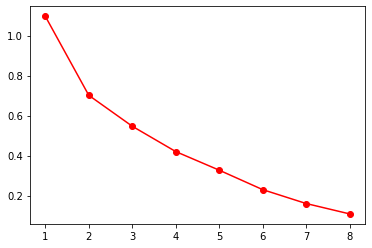

In [160]:
copenhagen_restaurants_clustering = copenhagen_grouped.drop('District', 1)

krange = range(1, 9)
inertias = []
for k in krange:
    model = KMeans(n_clusters=k).fit(copenhagen_restaurants_clustering)
    inertias.append(model.inertia_)
    
plt.plot(krange, inertias, 'ro-')
plt.show()

In [161]:
kclusters = 2
optimal_cluster_fit = model = KMeans(n_clusters=kclusters).fit(copenhagen_restaurants_clustering)
# check cluster labels generated for each row in the dataframe
optimal_cluster_fit.labels_

array([0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0], dtype=int32)

We merge the labelled neighbourhoods with the geographical information from before and drop the neighbourhoods that were not assigned a label.

In [162]:
# add clustering labels
copenhagen_summed.insert(1, 'Cluster Labels', optimal_cluster_fit.labels_)
copenhagen_summed

,District,Cluster Labels,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,Chinese Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,...,Scandinavian Restaurant,Seafood Restaurant,South American Restaurant,South Indian Restaurant,Spanish Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Amager Vest,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,Amager Øst,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,3,0,1,0,0
2,Bispebjerg,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,2,0,2,0,0
3,Brønshøj-Husum,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,2,0,0,0,0
4,Frederiksberg,0,0,0,1,0,1,0,0,5,...,6,0,0,1,0,3,0,2,0,0
5,Indre By,0,0,0,1,1,0,0,0,4,...,5,1,1,0,0,0,1,0,1,0
6,Nørrebro,0,1,0,0,0,0,2,0,1,...,2,2,0,0,1,1,1,3,1,1
7,Valby,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,4,0,1,0,1
8,Vanløse,0,0,0,0,0,0,0,3,0,...,2,0,0,0,0,1,0,0,0,0
9,Vesterbro/Kongens Enghave,0,0,0,0,0,1,1,1,0,...,5,2,0,1,0,1,1,1,0,1


In [163]:
copenhagen_merged = df_copenhagen
copenhagen_merged = copenhagen_merged.join(copenhagen_summed.set_index('District'), on='District')
copenhagen_merged

,District,Latitude,Longitude,Cluster Labels,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,Chinese Restaurant,Falafel Restaurant,...,Scandinavian Restaurant,Seafood Restaurant,South American Restaurant,South Indian Restaurant,Spanish Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Indre By,55.68,12.58,0,0,0,1,1,0,0,...,5,1,1,0,0,0,1,0,1,0
1,Østerbro,55.711,12.578,0,0,0,0,0,0,2,...,5,0,0,0,0,2,0,5,1,0
2,Nørrebro,55.688333,12.559722,0,1,0,0,0,0,2,...,2,2,0,0,1,1,1,3,1,1
3,Vesterbro/Kongens Enghave,55.6667,12.55,0,0,0,0,0,1,1,...,5,2,0,1,0,1,1,1,0,1
4,Valby,55.660833,12.503611,1,0,1,0,0,0,0,...,0,0,0,0,0,4,0,1,0,1
5,Vanløse,55.6875,12.48,0,0,0,0,0,0,0,...,2,0,0,0,0,1,0,0,0,0
6,Brønshøj-Husum,55.7075,12.4914,1,0,0,0,0,0,1,...,0,0,0,0,0,2,0,0,0,0
7,Bispebjerg,55.708333,12.533333,1,0,0,0,0,0,0,...,1,0,0,0,0,2,0,2,0,0
8,Amager Øst,55.6625,12.6253,1,0,0,0,0,0,0,...,1,0,0,0,0,3,0,1,0,0
9,Amager Vest,55.641667,12.578056,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


We plot the neighbourhoods on the map again, this time colour coded according to the cluster label. We see that most of the neighbourhoods are in the red cluster.

In [164]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(copenhagen_merged['Latitude'], copenhagen_merged['Longitude'], copenhagen_merged['District'], copenhagen_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [168]:
copenhagen_merged[copenhagen_merged['Cluster Labels'] == 0]

,District,Latitude,Longitude,Cluster Labels,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,Chinese Restaurant,Falafel Restaurant,...,Scandinavian Restaurant,Seafood Restaurant,South American Restaurant,South Indian Restaurant,Spanish Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Indre By,55.68,12.58,0,0,0,1,1,0,0,...,5,1,1,0,0,0,1,0,1,0
1,Østerbro,55.711,12.578,0,0,0,0,0,0,2,...,5,0,0,0,0,2,0,5,1,0
2,Nørrebro,55.688333,12.559722,0,1,0,0,0,0,2,...,2,2,0,0,1,1,1,3,1,1
3,Vesterbro/Kongens Enghave,55.6667,12.55,0,0,0,0,0,1,1,...,5,2,0,1,0,1,1,1,0,1
5,Vanløse,55.6875,12.48,0,0,0,0,0,0,0,...,2,0,0,0,0,1,0,0,0,0
9,Amager Vest,55.641667,12.578056,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
10,Frederiksberg,55.6775,12.533889,0,0,0,1,0,1,0,...,6,0,0,1,0,3,0,2,0,0


The first, and largest, cluster seems to be dominated by Coffee Shops.

In [167]:
copenhagen_merged[copenhagen_merged['Cluster Labels'] == 1]

,District,Latitude,Longitude,Cluster Labels,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,Chinese Restaurant,Falafel Restaurant,...,Scandinavian Restaurant,Seafood Restaurant,South American Restaurant,South Indian Restaurant,Spanish Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
4,Valby,55.660833,12.503611,1,0,1,0,0,0,0,...,0,0,0,0,0,4,0,1,0,1
6,Brønshøj-Husum,55.7075,12.4914,1,0,0,0,0,0,1,...,0,0,0,0,0,2,0,0,0,0
7,Bispebjerg,55.708333,12.533333,1,0,0,0,0,0,0,...,1,0,0,0,0,2,0,2,0,0
8,Amager Øst,55.6625,12.6253,1,0,0,0,0,0,0,...,1,0,0,0,0,3,0,1,0,0
